# 1  Exploring the Data

In [1]:
# load dataset
from sklearn.datasets import load_digits

digits=load_digits()

print(digits.keys())

digits = load_digits()
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]
print(target_names)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
[0 1 2 3 4 5 6 7 8 9]


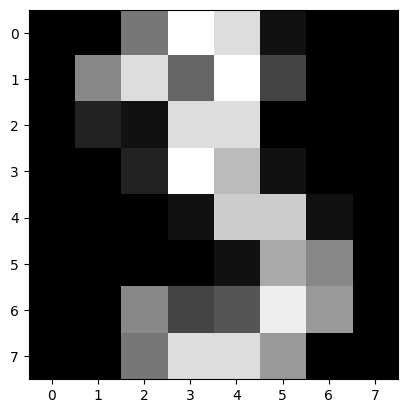

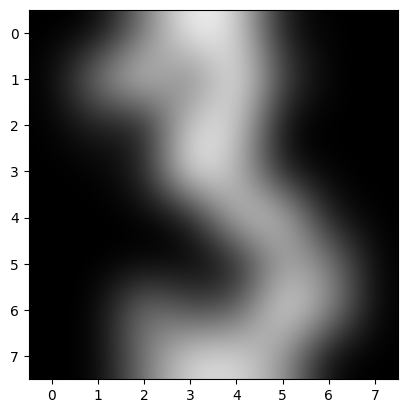

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#find an index with a value of three from target
img=images[np.array(np.where(target==3))[0][0],:,:]

assert 2==len(img.shape)

plt.figure()
plt.gray()
plt.imshow(img,interpolation="nearest")
plt.show()
plt.imshow(img, interpolation="bicubic")
plt.show()

In [3]:
from sklearn import model_selection

#filter 3 and 9
index =np.where((target==3) | (target==9))[0]
X_all=data[index]
y_all=target[index]

X_train,X_test,y_train,y_test=\
    model_selection.train_test_split(X_all, y_all, test_size=0.4, random_state=0)


# 2 Hand-crafted classifier

## 2.1 Feature Construction

In [4]:
import random

#find the pixel central of each image 
def feature2d(image): 
    random.seed(42)
    random_num=[random.random()*20-10 for i in range(64)]

    #choose feature1,feature2.
    if len(image.shape)==2:
        return np.array([sum([random_num[x]*image[x//8,x%8] for x in range(64)]),\
                         sum([random_num[-x]*image[x%8,x//8] for x in range(64)])])
    else:
        return np.array([sum([random_num[x]*image[x] for x in range(64)]),\
                         sum([random_num[-x]*image[x%8*8+x//8] for x in range(64)])])
    # #choose feature1,feature2.
    if len(image.shape)==2:
        return np.array([12*image[2,3]+42*image[3,4]*image[5,5],\
                         image[4,3]-image[5,6]*image[4,4]])
    else:
        return np.array([12*image[2*8+3]+42*image[3*8+4]*image[5*8+5],\
                         image[4*8+3]-image[5*8+6]*image[4*8+4]])

## 2.2 Scatterplot

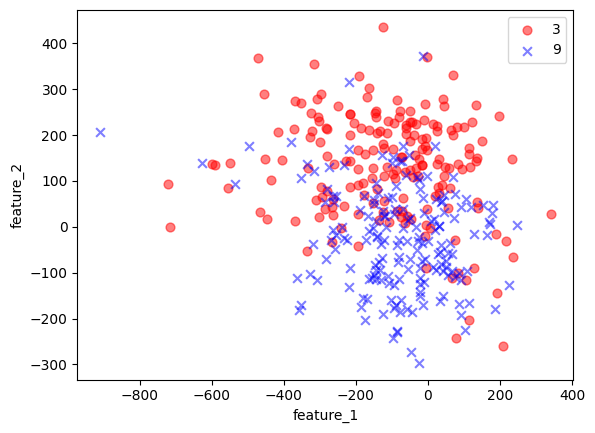

In [5]:
#feature construction
images_construction=np.array([feature2d(x) for x in images])
images3=images_construction[np.where(target==3)[0]]
images9=images_construction[np.where(target==9)[0]]
plt.figure()
plt.scatter(images3[:, 0], images3[:, 1], s=40, c='red', marker='o', alpha=0.5, label='3')
plt.scatter(images9[:, 0], images9[:, 1], s=40, c='blue', marker='x', alpha=0.5, label='9')
plt.xlabel("feature_1")
plt.ylabel("feature_2")
plt.legend()
plt.show()

## 2.3 Decision Rule

In [6]:
def calculate_distance(point_a,point_b):
    return np.sqrt(np.sum((point_a-point_b)**2))

def nearest_mean(training_features,tarining_labels,test_features):
    training_features_3=training_features[np.where(tarining_labels==3)[0]]
    training_features_9=training_features[np.where(tarining_labels==9)[0]]

    #computer average features
    ave_3=np.mean(training_features_3,axis=0)
    ave_9=np.mean(training_features_9,axis=0)

    predicted_labels=np.array([3 if calculate_distance(ave_3,x)<=\
                               calculate_distance(ave_9,x) else 9 for x in test_features ])
    
    return predicted_labels

In [7]:
def error_rate(y_true, y_pred):
    assert len(y_true)==len(y_pred)

    return sum([1 if y_pred[i]!=y_true[i] else 0 for i in range(len(y_pred))])/len(y_true)

#feature construction
training_features=np.array([feature2d(x) for x in X_train])
test_features=np.array([feature2d(x) for x in X_test])

predicted_labels=nearest_mean(training_features,y_train,test_features)

#computer error ratio which is (FP+FN)/N
error_ratio = error_rate(y_test , predicted_labels)
print("error ratio is:{}".format(error_ratio))

error ratio is:0.22602739726027396


## 2.4 Visualize the decision regions

C:\Users\WY\AppData\Local\Temp\ipykernel_142240\3858934958.py:18: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(X, Y, y_predict_matrix, linewidth=5, cmap=my_colormap)


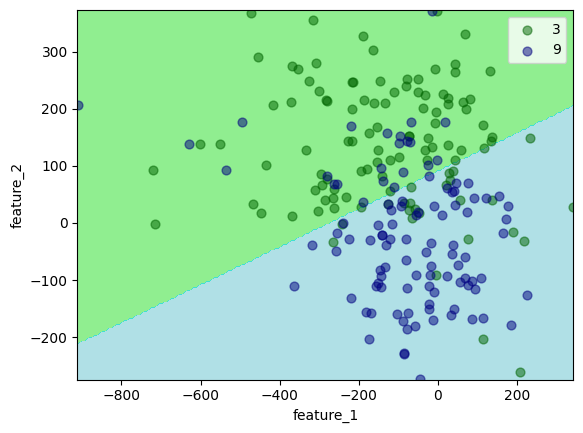

In [8]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(training_features,tarining_labels):
    x1_min,x1_max = training_features[:,0].min()-1,training_features[:,0].max()+1
    x2_min,x2_max = training_features[:,1].min()-1,training_features[:,1].max()+1
    X,Y=np.meshgrid(
        np.linspace(x1_min, x1_max, 200),
        np.linspace(x2_min, x2_max, 200),
        )
    
    grid_matrix = np.c_[X.ravel(), Y.ravel()]

    y_predict = nearest_mean(training_features,tarining_labels,grid_matrix)
    y_predict_matrix = y_predict.reshape(X.shape)

    my_colormap = ListedColormap(['#90EE90', '#40E0D0', '#B0E0E6'])

    plt.contourf(X, Y, y_predict_matrix, linewidth=5, cmap=my_colormap)
    
    train_3=training_features[np.where(tarining_labels==3)[0]]
    train_9=training_features[np.where(tarining_labels==9)[0]]
    plt.scatter(train_3[:, 0], train_3[:, 1], s=40, c='#006400', marker='o', alpha=0.5, label='3')
    plt.scatter(train_9[:, 0], train_9[:, 1], s=40, c='#000080', marker='o', alpha=0.5, label='9')
    plt.xlabel("feature_1")
    plt.ylabel("feature_2")
    plt.legend()
    plt.show()
    
plot_decision_boundary(training_features,y_train)


# 3 LDA

## 3.1 Implement LDA training

In [9]:
import copy
def fit_lda(training_features,training_labels):
    assert training_features.shape[0]==len(training_labels)

    #each time find different class index to calculate mu and p
    labels=np.unique(training_labels)
    mu=np.empty(( len(labels),training_features.shape[1] ))
    p=np.empty((len(labels),1))
    covmat=np.zeros(( training_features.shape[1],training_features.shape[1] ))
    for i in range(len(labels)):
        mu[i]=np.mean(training_features[np.where(training_labels==labels[i])[0]],axis=0).reshape(1,-1)
        p[i]=len(training_features[np.where(training_labels==labels[i])[0]])/len(training_labels)

    #according to the previously calculated mu to calculate covarince
    for i in range(len(labels)):
        temp=training_features[np.where(training_labels==labels[i])[0]]-mu[i]
        covmat=covmat+temp.T.dot(temp)
    covmat=covmat/len(training_labels)

    return mu,covmat,p
    
y_train_lda=copy.deepcopy(y_train)

y_train_lda[y_train_lda==3]=-1
y_train_lda[y_train_lda==9]=1
mu,covmat,p=fit_lda(X_train,y_train_lda)
print(mu.shape)
print(covmat.shape)
print(p.shape)

mu_task2,covmat_task2,p_task2=fit_lda(training_features,y_train_lda)
print(mu_task2)
print(covmat_task2)
print(p_task2)


(2, 64)
(64, 64)
(2, 1)
[[-129.45437642  134.97175365]
 [ -76.64764777  -23.68932899]]
[[33337.12817921 -3660.89521133]
 [-3660.89521133 12721.07399574]]
[[0.51152074]
 [0.48847926]]


In [10]:
#Because covmat is a singular matrix, 
#pca is used to reduce the dimensions to non-singular dimensions and convert the original data.
def data_transform(training_features,training_labels,test_features):
    training_features_std=np.var(training_features,axis=0)
    index=np.where(training_features_std<=0.001)[0]
    training_features=np.delete(training_features,index,axis=1)
    test_features=np.delete(test_features,index,axis=1)

    training_features_ave=np.mean(training_features,axis=0)
    training_features=training_features-training_features_ave

    #each time find different class index to calculate mu and p
    labels=np.unique(training_labels)
    mu=np.empty(( len(labels),training_features.shape[1] ))
    p=np.empty((len(labels),1))
    covmat=np.zeros(( training_features.shape[1],training_features.shape[1] ))
    for i in range(len(labels)):
        mu[i]=np.mean(training_features[np.where(training_labels==labels[i])[0]],axis=0).reshape(1,-1)
        p[i]=len(training_features[np.where(training_labels==labels[i])[0]])/len(training_labels)

    #according to the previously calculated mu to calculate covarince
    for i in range(len(labels)):
        temp=training_features[np.where(training_labels==labels[i])[0]]-mu[i]
        covmat=covmat+temp.T.dot(temp)

    eig_value,eig_vector=np.linalg.eig(covmat)
    sort_index=eig_value.argsort()
    eig_value=eig_value[sort_index[::-1]]
    eig_vector=eig_vector[sort_index[::-1]]
    index=np.where(eig_value>0)[0]
    index=index[0:-8]
    eig_value=eig_value[index]
    eig_vector=eig_vector[index]
    
    X_train_lda=training_features.dot(eig_vector.T)
    X_test_lda=test_features.dot(eig_vector.T)
    return X_train_lda,X_test_lda

X_train_lda,X_test_lda=data_transform(X_train,y_train_lda,X_test)
X_train_lda_task2,X_test_lda_task2=data_transform(training_features,y_train_lda,test_features)

mu,covmat,p=fit_lda(X_train_lda,y_train_lda)
print(mu.shape)
print(covmat.shape)

(2, 45)
(45, 45)


## 3.2 Implement LDA prediction

In [11]:
def sigmoid(x):
  
    z = np.exp(-x)
    sig = 1 / (1 + z)

    return sig

def predicted_lda(mu,covmat,p,test_features):
    covmat_inv=np.linalg.inv(covmat)

    w=covmat_inv.dot(mu[1]-mu[0])
    b=-(mu[0]+mu[1]).dot(w)/2+np.log(p[1]/p[0])

    predicted_labels=sigmoid(test_features.dot(w)+b)
    predicted_labels[predicted_labels>=0.5]=1
    predicted_labels[predicted_labels<0.5]=-1
    
    return predicted_labels

predicted_labels=predicted_lda(mu,covmat,p,X_test_lda)

predicted_labels_task2=predicted_lda(mu_task2,covmat_task2,p_task2,test_features)

In [12]:
#computer error ratio which is (FP+FN)/N
y_test_lda=copy.deepcopy(y_test)
y_test_lda[y_test_lda==3]=-1
y_test_lda[y_test_lda==9]=1

error_ratio = error_rate(y_test_lda , predicted_labels)
print("error ratio is:{}".format(error_ratio))
error_ratio = error_rate(y_test_lda , predicted_labels_task2)
print("error ratio is:{}".format(error_ratio))

error ratio is:0.0410958904109589
error ratio is:0.2328767123287671


## 3.3 Visualization

C:\Users\WY\AppData\Local\Temp\ipykernel_142240\2634693815.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(X, Y, y_predict_matrix,linewidth=5, cmap=my_colormap)


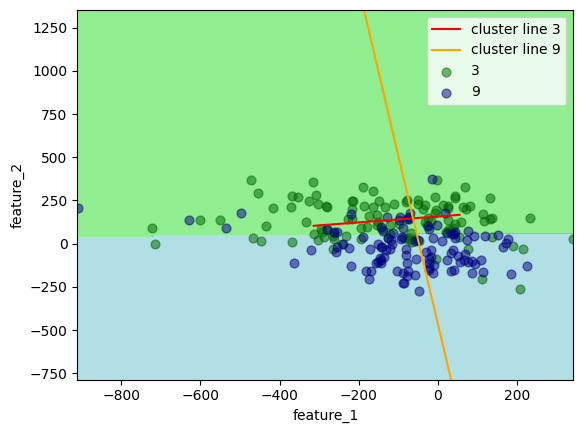

In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(training_features,tarining_labels,mu,covmat,p):
    eig_values,eig_vector=np.linalg.eig(covmat)
    eig_values=np.sqrt(eig_values)

    k=eig_vector[:,1]/eig_vector[:,0]
    b=mu[:,1]-k*mu[:,0]

    x_1=np.linspace(mu[0,0]-eig_values[0],mu[0,0]+eig_values[0],5)
    x_2=np.linspace(mu[1,0]-eig_values[1],mu[1,0]+eig_values[1],5)
    y_1=k[0]*x_1+b[0]
    y_2=k[1]*x_1+b[1]

    x1_min,x1_max = training_features[:,0].min()-1,training_features[:,0].max()+1
    x2_min,x2_max = training_features[:,1].min()-1,training_features[:,1].max()+1
     
    X,Y=np.meshgrid(
        np.linspace(x1_min, x1_max, 200),
        np.linspace(y_2[-1], y_2[0], 200),
        )
    
    grid_matrix = np.c_[X.ravel(), Y.ravel()]

    y_predict = predicted_lda(mu,covmat,p,grid_matrix)
    y_predict_matrix = y_predict.reshape(X.shape)

    my_colormap = ListedColormap(['#90EE90', '#40E0D0', '#B0E0E6'])

    plt.contourf(X, Y, y_predict_matrix,linewidth=5, cmap=my_colormap)

    plt.plot(x_1,y_1,label="cluster line 3",c='red')
    plt.plot(x_2,y_2,label="cluster line 9",c='orange')
    
    train_3=training_features[np.where(tarining_labels==3)[0]]
    train_9=training_features[np.where(tarining_labels==9)[0]]
    plt.scatter(train_3[:, 0], train_3[:, 1], s=40, c='#006400', marker='o', alpha=0.5, label='3')
    plt.scatter(train_9[:, 0], train_9[:, 1], s=40, c='#000080', marker='o', alpha=0.5, label='9')
    plt.xlabel("feature_1")
    plt.ylabel("feature_2")
    plt.legend()
    plt.show()

plot_decision_boundary(training_features,y_train,mu_task2,covmat_task2,p_task2)

## 3.4 Quantitative performance evaluation

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_predict,StratifiedKFold
import copy

lda = LDA()

pred = cross_val_predict(lda, X_all, y_all, cv=10)
correct_pred = np.mean(np.equal(pred, y_all))
print('sklearn.lda accuracy with 64D: {}'.format(correct_pred))

training_features_t = np.array([feature2d(x) for x in X_all])
pred = cross_val_predict(lda, training_features_t, y_all, cv=10)
correct_pred = np.mean(np.equal(pred, y_all))
print('sklearn.lda accuracy with 2D: {}'.format(correct_pred))

k_folds=StratifiedKFold(n_splits=10)

#64D
y_test_lda=copy.deepcopy(y_all)
y_test_lda[y_test_lda==3]=-1
y_test_lda[y_test_lda==9]=1
acc_ave=0
for train_index,test_index in k_folds.split(X_all,y_test_lda):
    training_folds=X_all[train_index]
    training_labels_folds=y_test_lda[train_index]

    test_folds=X_all[test_index]
    test_labels_folds=y_test_lda[test_index]

    training_folds,test_folds=data_transform(training_folds,training_labels_folds,test_folds)
    mu,covmat,p=fit_lda(training_folds,training_labels_folds)
    predicted_labels=predicted_lda(mu,covmat,p,test_folds)
    error_ratio = error_rate(test_labels_folds , predicted_labels)
    acc_ave=acc_ave+1-error_ratio
acc_ave=acc_ave/10
print("lda accuracy with 64D:{}".format(acc_ave))

#2D
for train_index,test_index in k_folds.split(training_features_t,y_test_lda):
    training_folds=training_features_t[train_index]
    training_labels_folds=y_test_lda[train_index]

    test_folds=training_features_t[test_index]
    test_labels_folds=y_test_lda[test_index]

    mu,covmat,p=fit_lda(training_folds,training_labels_folds)
    predicted_labels=predicted_lda(mu,covmat,p,test_folds)
    error_ratio = error_rate(test_labels_folds , predicted_labels)
    acc_ave=acc_ave+1-error_ratio
acc_ave=acc_ave/10
print("lda accuracy with 2D:{}".format(acc_ave))

sklearn.lda accuracy with 64D: 0.977961432506887
sklearn.lda accuracy with 2D: 0.743801652892562
lda accuracy with 64D:0.9253753753753754
lda accuracy with 2D:0.8369819819819819


# 4 SVM

## 4.1 Implement SVM training

In [15]:
from sklearn.model_selection import StratifiedKFold
def fit_svm(training_features,training_labels,epsilon=[0.1,1e-2,1e-3,1e-4],learning_rate="adaptive",eta0=0.01,max_iter=2000,k_fold_num=5,n_iter_no_change=5):
    """
    input:
        training_features  -   N*D matrix
        training_labels    -   two class:-1,1
        epsilon            -   hyperparameter lamda,usually a list[0.01,1e-2,1e-3]
        learning_rate      -   two types:"adaptive":learning rate will decrease if loss not change after n iters,
                                         "constant":no change learning rate
        eta0               -   initial learning rate
        max_iter           -   max iteration num
        k_fold_num         -   cross validation to find the best hyperparameter in alpha list
        n_iter_no_change   -   number of iterations with no improvement to wait before stopping fitting
    """
    assert training_features.shape[0]==len(training_labels)
    assert n_iter_no_change<max_iter
    assert n_iter_no_change>=0 and max_iter>0 and eta0>0
    assert learning_rate=="adaptive" or learning_rate=="constant"



    def train(X_train,Y_train,X_test=None,Y_test=None,eps=0.1,learning_rate="adaptive",eta0=1e-2,max_iter=5000,n_iter_no_change=5):
        assert X_train.shape[0]==len(Y_train)

        if Y_test is not None:
            assert X_test.shape[0]==len(Y_test)

        w=np.random.normal(0,1,(X_train.shape[1],1))
        b=np.array([0])

        #decide learning_rate loop to decrease if check time.
        loss_curve=[]
        train_error=[]
        if learning_rate=="adaptive":
            loss_last_iter=0
            iter_no_change_time=0
            for i in range(max_iter):
                z=np.multiply(X_train.dot(w)+b,Y_train.reshape(-1,1))
                temp=1-z
                temp=(np.abs(temp)+temp)/2
                loss=np.sum(temp)*eps/X_train.shape[0]
                loss=loss+w.T.dot(w)/2

                if np.abs(loss-loss_last_iter)<1e-5:
                    iter_no_change_time=iter_no_change_time+1
                if iter_no_change_time>=n_iter_no_change:
                    eta0=eta0/10
                    iter_no_change_time=0
                
                loss_last_iter=loss
                loss_curve.append(loss)

                index=np.where(temp!=0)[0]

                w=w-(eta0*(np.sum(-Y_train[index].reshape(-1,1)*X_train[index],axis=0))/X_train.shape[0]).reshape(-1,1)
                b=b-eta0*np.sum(-Y_train[index])/X_train.shape[0]

                pred=X_train.dot(w)+b
                pred[pred>=0]=1
                pred[pred<0]=-1
                pred=sum([1 if pred[i]!=Y_train[i] else 0 for i in range(len(pred))])/X_train.shape[0]
                train_error.append(pred)
        else:
            for i in range(max_iter):
                z=np.multiply(X_train.dot(w)+b,Y_train.reshape(-1,1))
                temp=1-z
                temp=(np.abs(temp)+temp)/2
                loss=np.sum(temp)*eps/X_train.shape[0]
                loss=loss+w.T.dot(w)/2
                loss_curve.append(loss)

                index=np.where(temp!=0)[0]

                w=w-(eta0*(np.sum(-Y_train[index].reshape(-1,1)*X_train[index],axis=0))/X_train.shape[0]).reshape(-1,1)
                b=b-eta0*np.sum(-Y_train[index])/X_train.shape[0]

                pred=X_train.dot(w)+b
                pred[pred>=0]=1
                pred[pred<0]=-1
                pred=sum([1 if pred[i]!=Y_train[i] else 0 for i in range(len(pred))])/X_train.shape[0]
                train_error.append(pred)
                
        loss_curve=[i[0][0] for i in loss_curve]
        if Y_test  is not None:
            pred=X_test.dot(w)+b
            pred[pred>=0]=1
            pred[pred<0]=-1
            pred=sum([0 if pred[i]!=Y_test[i] else 1 for i in range(len(pred))])
            return pred/X_test.shape[0]
        else:
            return w,b,loss_curve,train_error
    
    #first use cross validation to fine the best epsilon
    acc=[]
    for eps in epsilon:
        k_folds=StratifiedKFold(n_splits=k_fold_num)

        acc_ave=0
        for train_index,test_index in k_folds.split(training_features,training_labels):
            training_folds=training_features[train_index]
            training_labels_folds=training_labels[train_index]

            test_folds=training_features[test_index]
            test_labels_folds=training_labels[test_index]

            acc_ave=acc_ave+train(training_folds,training_labels_folds,test_folds,test_labels_folds,eps,learning_rate,eta0,max_iter,n_iter_no_change)
        acc_ave=acc_ave/k_fold_num
        acc.append(acc_ave)
    
    #find the best epsilon
    eps_best=epsilon[acc.index(max(acc))]

    w,b,loss,train_error=train(training_features,training_labels,None,None,eps_best,learning_rate,eta0,max_iter,n_iter_no_change)
    
    return w,b,loss,train_error
    

y_train_svm=copy.deepcopy(y_train)

y_train_svm[y_train_svm==3]=-1
y_train_svm[y_train_svm==9]=1

w,b,loss,train_error=fit_svm(X_train,y_train_svm)
w_taks2,b_task2,loss_task2,train_error_task2=fit_svm(training_features,y_train_svm,eta0=0.001)

## 4.2 Impleement SVM prediction

In [16]:
def predicted_svm(w,b,test_features):
    pred=test_features.dot(w)+b
    pred[pred>=0]=1
    pred[pred<0]=-1
    return pred
   

predicted_labels_svm=predicted_svm(w,b,X_test)
predicted_labels_svm_task2=predicted_svm(w_taks2,b_task2,test_features)

In [17]:
#computer error ratio which is (FP+FN)/N
y_test_svm=copy.deepcopy(y_test)
y_test_svm[y_test_svm==3]=-1
y_test_svm[y_test_svm==9]=1

error_ratio = error_rate(y_test_svm , predicted_labels_svm)
error_ratio_task2 = error_rate(y_test_svm , predicted_labels_svm_task2)
print("64 features error ratio is:{}".format(error_ratio))
print("task2 2 features error ratio is:{}".format(error_ratio_task2))

64 features error ratio is:0.02054794520547945
task2 2 features error ratio is:0.2602739726027397


## 4.3 Visualization

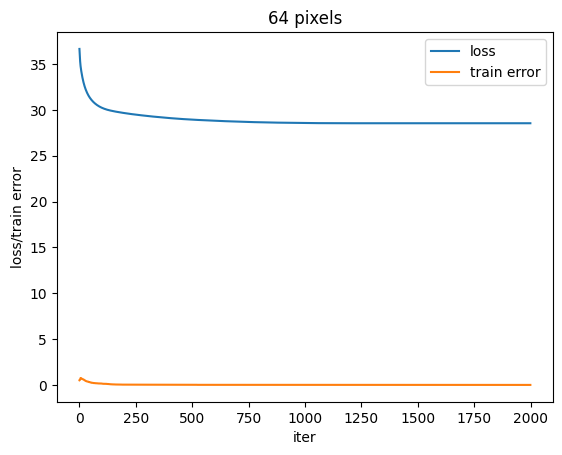

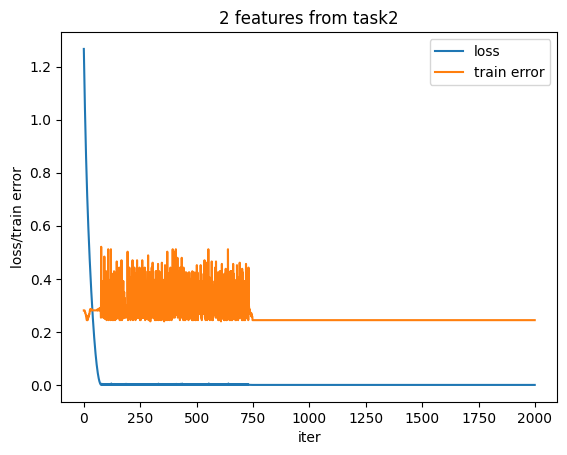

C:\Users\WY\AppData\Local\Temp\ipykernel_142240\605482007.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(X, Y, y_predict_matrix, linewidth=5, cmap=my_colormap)


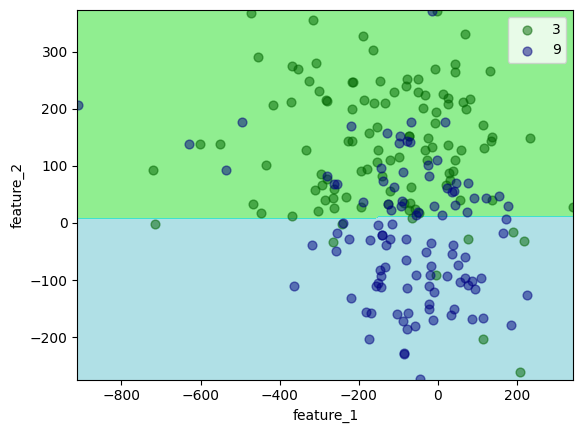

In [18]:
import matplotlib.pyplot as plt
#loss curve
def loss_curve(loss,train_error,title=""):
    x=[i for i in range(len(loss))]
    y1=loss
    y2=train_error

    plt.plot(x,y1,label="loss")
    plt.plot(x,y2,label="train error")
    plt.xlabel("iter")
    plt.ylabel("loss/train error")
    plt.legend()
    plt.title(title)
    plt.show()

#boundary decision
def plot_decision_boundary(training_features,tarining_labels,w,b):
    x1_min,x1_max = training_features[:,0].min()-1,training_features[:,0].max()+1
    x2_min,x2_max = training_features[:,1].min()-1,training_features[:,1].max()+1
    X,Y=np.meshgrid(
        np.linspace(x1_min, x1_max, 200),
        np.linspace(x2_min,x2_max, 200),
        )
    
    grid_matrix = np.c_[X.ravel(), Y.ravel()]

    y_predict = predicted_svm(w,b,grid_matrix)
    y_predict_matrix = y_predict.reshape(X.shape)

    my_colormap = ListedColormap(['#90EE90', '#40E0D0', '#B0E0E6'])

    plt.contourf(X, Y, y_predict_matrix, linewidth=5, cmap=my_colormap)
    
    train_3=training_features[np.where(tarining_labels==3)[0]]
    train_9=training_features[np.where(tarining_labels==9)[0]]
    plt.scatter(train_3[:, 0], train_3[:, 1], s=40, c='#006400', marker='o', alpha=0.5, label='3')
    plt.scatter(train_9[:, 0], train_9[:, 1], s=40, c='#000080', marker='o', alpha=0.5, label='9')
    plt.xlabel("feature_1")
    plt.ylabel("feature_2")
    plt.legend()
    plt.show()
    
#draw features from task2
loss_curve(loss,train_error,"64 pixels")
loss_curve(loss_task2,train_error_task2,"2 features from task2")
plot_decision_boundary(training_features,y_train,w_taks2,b_task2)


## 4.4 Quantitative performance evaluation

In [20]:
#Compare with skelearn SVM
from sklearn.model_selection import cross_val_score
#Compare with skelearn SVM
from sklearn import svm
svm = svm.SVC()
pred = cross_val_predict(svm, X_all, y_all, cv=10)
correct_pred = np.mean(np.equal(pred, y_all))
print('sklearn.svm accuracy with 64D: {}'.format(correct_pred))

training_features_t = np.array([feature2d(x) for x in X_all])
pred = cross_val_predict(svm, training_features_t, y_all, cv=10)
correct_pred = np.mean(np.equal(pred, y_all))
print('sklearn.svm accuracy with 2D: {}'.format(correct_pred))

k_folds=StratifiedKFold(n_splits=10)

#64D
y_test_lda=copy.deepcopy(y_all)
y_test_lda[y_test_lda==3]=-1
y_test_lda[y_test_lda==9]=1
acc_ave=0
for train_index,test_index in k_folds.split(X_all,y_test_lda):
    training_folds=X_all[train_index]
    training_labels_folds=y_test_lda[train_index]

    test_folds=X_all[test_index]
    test_labels_folds=y_test_lda[test_index]

    w,b,loss,train_error=fit_svm(training_folds,training_labels_folds)
    predicted_labels=predicted_svm(w,b,test_folds)
    error_ratio = error_rate(test_labels_folds , predicted_labels)
    acc_ave=acc_ave+1-error_ratio
acc_ave=acc_ave/10
print("svm accuracy with 64D:{}".format(acc_ave))

#2D
for train_index,test_index in k_folds.split(training_features_t,y_test_lda):
    training_folds=training_features_t[train_index]
    training_labels_folds=y_test_lda[train_index]

    test_folds=training_features_t[test_index]
    test_labels_folds=y_test_lda[test_index]

    w,b,loss,train_error=fit_svm(training_folds,training_labels_folds)
    predicted_labels=predicted_svm(w,b,test_folds)
    error_ratio = error_rate(test_labels_folds , predicted_labels)
    acc_ave=acc_ave+1-error_ratio
acc_ave=acc_ave/10
print("svm accuracy with 2D:{}".format(acc_ave))

sklearn.svm accuracy with 64D: 0.9944903581267218
sklearn.svm accuracy with 2D: 0.7768595041322314
svm accuracy with 64D:0.9588588588588589
svm accuracy with 2D:0.7269669669669668


We can see that part of the feature information after the general task2 feature engineering process is lost, so generally speaking, the accuracy is not as good as the full information. The accuracy of svm is better than nearest and lda.